Практична робота 9. Використання tensorflow для побудови нейронної мережи
Роботу виконав: Плескач Матвій Русланович ФІТ 4-6

In [1]:
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist
import matplotlib.pyplot as plt
import numpy as np


Задання параметрів таких як: кількість класів, кількість атрибутів, швидкість навчання, кількість епох, перерахування вагів, відображення поточних значень через кожні 100 ітерацій, кількість нейронів.

In [2]:
num_classes = 10
num_features = 784

learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100

n_hidden_1 = 128
n_hidden_2 = 256

Завантаження дата сету, нормалізація, розбиття на тренувальні дані.

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

Створення нейронної мережі, та задаємо кількість нейронів на першому, другому на вихідному шарі.

In [4]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
        self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
        self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

    def __call__(self, x):

        x1 = self.layer_1(x, activation=0)
        x2 = self.layer_2(x1, activation=0)
        x3 = self.layer_3(x2, activation=1)
        return x3

Створення функції помилки та точності

In [5]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

Створення функції навчання

In [6]:
neural_net = NN(name="fashion_mnist")

def train(nn, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)

    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        trainable_variables = nn.trainable_variables
        gradients = g.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

Тренування мережі на тренувальному датасеті

In [7]:
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step: 0, Loss: 3091.0849609375, Accuracy: 0.1875
Step: 100, Loss: 1145.75048828125, Accuracy: 0.625
Step: 200, Loss: 1207.0760498046875, Accuracy: 0.625
Step: 300, Loss: 1081.922119140625, Accuracy: 0.67578125
Step: 400, Loss: 1215.90869140625, Accuracy: 0.640625
Step: 500, Loss: 1310.78466796875, Accuracy: 0.640625
Step: 600, Loss: 1373.9764404296875, Accuracy: 0.65234375
Step: 700, Loss: 1057.9273681640625, Accuracy: 0.671875
Step: 800, Loss: 1288.9854736328125, Accuracy: 0.6328125
Step: 900, Loss: 1128.1064453125, Accuracy: 0.6640625
Step: 1000, Loss: 1037.274169921875, Accuracy: 0.69921875
Step: 1100, Loss: 1415.42529296875, Accuracy: 0.6015625
Step: 1200, Loss: 1199.0303955078125, Accuracy: 0.6796875
Step: 1300, Loss: 1151.525390625, Accuracy: 0.65234375
Step: 1400, Loss: 1179.039306640625, Accuracy: 0.65625
Step: 1500, Loss: 807.3893432617188, Accuracy: 0.75
Step: 1600, Loss: 1112.2774658203125, Accuracy: 0.69140625
Step: 1700, Loss: 459.05682373046875, Accuracy: 0.6796875
Step: 

Побудова графіку залежності зміни точності та втрат від кожного кроку

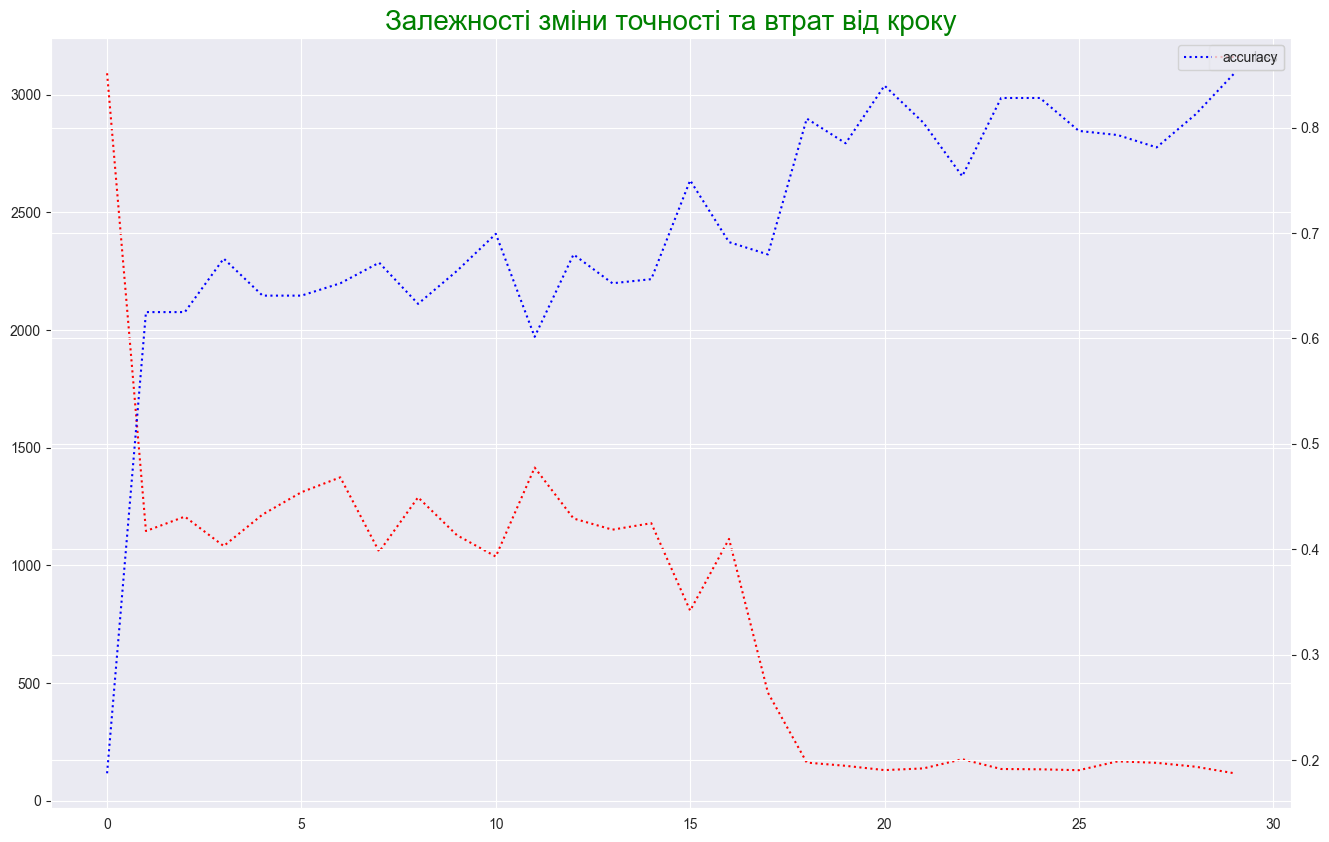

In [8]:
fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(loss_history, 'r', label='loss', linestyle=":")
axs.legend()

axs2=axs.twinx()
axs2.plot(accuracy_history, 'b', label='accuracy', linestyle=":")
plt.legend()

plt.title('Залежності зміни точності та втрат від кроку', fontsize=20, color='g')
plt.show()

Точність мережі

In [9]:
neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {neural_net_accuracy}")

Accuracy: 0.8196666836738586


Тести навченної мережі

True: 3 Predict: 3 True
True: 2 Predict: 2 True
True: 1 Predict: 1 True
True: 4 Predict: 6 False
True: 2 Predict: 3 False
True: 9 Predict: 9 True
True: 9 Predict: 9 True
True: 6 Predict: 3 False
True: 2 Predict: 2 True
True: 2 Predict: 2 True


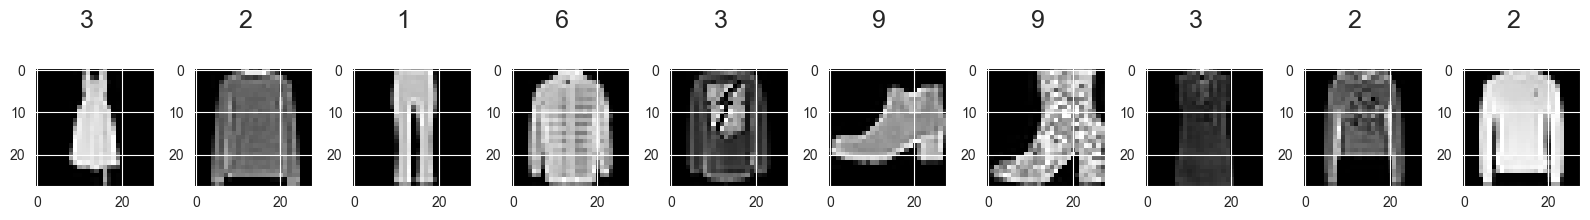

In [10]:
test_img = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]

plt.figure(figsize=(16, 6))
for i in range(10):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)

plt.tight_layout()
plt.show()

Висновок:Під час виконання цієї лабораторної роботи отримав навички роботи з tensorflow та keras, побудував нейромережу для класифікації типів одягу. Данна нейромережа має точність 0.819. Також в ході роботи був розроблений графік функції втрат і точності.